# Readme

Code for the bouncing ball example in "Learning Hybrid Control Barrier Functions from Data"

Instructions: 
1.   Simply run the blocks top-down to reproduce our results
2.   Upload the training data: X_train_cts.npy, U_train_cts.npy in the data folder (optional) 
3.   Upload the learned HCBF: params.npy in the network folder (optional)



# Part 0: Packages and Functions

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

In [36]:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Hybrid CBF/file')

%matplotlib inline
import numpy as np
import scipy
import matplotlib.pylab as plt

import os
import pickle
import importlib

import jax.numpy as jnp
import jax.scipy as jsp
from jax import random, vmap, jit, grad, ops, lax, tree_util, device_put, device_get, jacobian, jacfwd, jacrev, jvp
from jax.flatten_util import ravel_pytree
from jax.experimental import optimizers

from functools import partial
import time

# import util
# importlib.reload(util)

import scipy
import scipy.spatial

import cvxpy as cp

## 0.1 Hybrid integrator

In [33]:
import numpy as np
import jax.numpy as jnp
import scipy
import scipy.integrate
import copy

from absl import logging

DIR_NEGATIVE_TO_POSITIVE = 1.0
DIR_POSITIVE_TO_NEGATIVE = -1.0
DIR_EITHER = 0.0


def _proxy(f):
    return lambda *args, **kwargs: f(*args, **kwargs)


def hybrid_integration(
        f, event, direction, guard, y0_dct, y0_cts, dct_action, t0, tf, switch_callback=None):

    assert direction == DIR_POSITIVE_TO_NEGATIVE, "limitation for now"

    if switch_callback is None:
        # no-op switch_callback
        switch_callback = lambda *args, **kwargs: None

    def make_scipy_event(event, direction, terminal):
        fn = _proxy(event)
        fn.direction = direction
        fn.terminal = terminal
        return fn

    event_flag = False

    ycur_dct = y0_dct
    ycur_cts = y0_cts
    tcur = t0

    GUARD_TOL = 1e-4
    PROGRESS_TOL = 1e-4

    method = "RK45"
    while True:

        cur_witness = event(tcur, ycur_cts)
        if cur_witness >= 0 and cur_witness <= GUARD_TOL:
            logging.debug("cur_witness %f, tcur %f", cur_witness, tcur)
            # avoid getting stuck
            res = scipy.integrate.solve_ivp(f, (tcur, tf), ycur_cts,
                                            dense_output=True,
                                            events=[make_scipy_event(event, direction, terminal=False)],
                                            method=method)
            if res.status == -1:
                raise ValueError("integration failed: {}".format(res.message))
            elif res.status == 1:
                raise RuntimeError("non_terminal event should not trigger")
            assert res.status == 0
            t_events, = res.t_events
            t_events = np.sort(t_events)
            t_events = t_events[np.where(t_events > (tcur + PROGRESS_TOL))]
            if len(t_events) == 0:
                # no event fired outside of the interval [tcur, tcur + PROGRESS_TOL],
                # which we are choosing to ignore in order to make progress
                return ycur_dct, res.sol(tf), event_flag
            logging.debug("t_events %s", t_events)
            tcur = t_events[0]
            ycur_dct_before = np.array(ycur_dct)
            ycur_cts_before = res.sol(tcur)
            ycur_dct, ycur_cts = guard(tcur, ycur_dct, ycur_cts_before, dct_action)
            switch_callback(tcur,
                    ycur_dct_before, ycur_cts_before,
                    ycur_dct, ycur_cts)
            event_flag = True
        else:
            # we are confident that we can make enough forward progress before
            # the next event
            res = scipy.integrate.solve_ivp(f, (tcur, tf), ycur_cts,
                                            dense_output=True,
                                            events=[make_scipy_event(event, direction, terminal=True)],
                                            method=method)
            if res.status == -1:
                raise ValueError("integration failed: {}".format(res.message))
            elif res.status == 0:
                # reached end of timespan
                return ycur_dct, res.sol(tf), event_flag
            elif res.status == 1:
                t_events, = res.t_events
                t_events = np.sort(t_events)
                tcur = t_events[0]
                ycur_dct_before = np.array(ycur_dct)
                ycur_cts_before = res.sol(tcur)
                ycur_dct, ycur_cts = guard(tcur, ycur_dct, ycur_cts_before, dct_action)
                switch_callback(tcur,
                        ycur_dct_before, ycur_cts_before,
                        ycur_dct, ycur_cts)
                event_flag = True

## 0.2 Bouncing ball simulator and controller

In [34]:
import jax.numpy as jnp
import jax.scipy as jsp

import numpy as np
import scipy
import scipy.integrate
import scipy.interpolate
import cvxpy as cp

from absl import logging

from jax import device_get
from jax import lax
from jax import grad

# enable float64
from jax.config import config
config.update('jax_enable_x64', True)

from collections import namedtuple
from functools import partial

# import integrators


BouncingBallContext = namedtuple('BouncingBallContext',
        ['continuous_state',  'discrete_state', 'params'])
BouncingBallParams = namedtuple('BouncingBallParams',
        ['gamma', 'vel_bound'])

# global parameters
_GRAVITY = 9.81
_VEL_BOUND = 2.0
_dt = 0.01

# continuous state indices
_POS = 0
_VEL = 1

# discrete state indices

# enable/disable jit
_DISABLE_JIT = False
if _DISABLE_JIT:
    print("WARNING: jit is disabled")


def _jit(*args, **kwargs):
    if _DISABLE_JIT:
        return args[0]
    else:
        from jax import jit
        return jit(*args, **kwargs)


@partial(_jit, static_argnums=(2,))
def ContinuousDynamics(cts_state, cts_action, params):
    return jnp.array([cts_state[_VEL], cts_action-params.gamma])


@partial(_jit, static_argnums=(1,))
def CollisionWitness(cts_state, params):
    return cts_state[_POS]


@partial(_jit, static_argnums=(3,))
def CollisionDynamics(dct_state, cts_state, dct_action, params):
    next_dct_state = dct_state # TODO
    # next_cts_state = jnp.array([cts_state[_POS], -dct_action * cts_state[_VEL]])
    next_cts_state = jnp.array([0.0, -dct_action * cts_state[_VEL]])
    return next_dct_state, next_cts_state


def dynamics_f(cts_state, params=None):
    if params is None:
      gamma = _GRAVITY
    else:
      gamma = params.gamma
    return np.array([cts_state[_VEL], -gamma])


def dynamics_g(cts_state):
    return np.array([0.0, 1.0])


def h_trueCBF(cts_state, params=None):
    if params is None:
      vel_bound = _VEL_BOUND
    else:
      vel_bound = params.vel_bound
    return vel_bound**2 - cts_state[_VEL]**2


def grad_h_trueCBF(cts_state):
    return np.array([0.0, -2*cts_state[_VEL]])


def q_trueCBF(cts_state, safe_cts_action):
    f = dynamics_f(cts_state)
    g = dynamics_g(cts_state)
    hx = h_trueCBF(cts_state)
    dh = grad_h_trueCBF(cts_state)
    return np.dot(dh, f) + safe_cts_action * np.dot(g.T, dh) + hx**3


class BouncingBallEnv(object):

    def __init__(self, dt, horizon, rng=None, switch_callback=None):
        self.dt = dt
        self.horizon = horizon
        self.rng = rng if rng is not None else np.random
        self.params = BouncingBallParams(_GRAVITY, _VEL_BOUND)
        self.cts_action_lower_bound = -10
        self.cts_action_upper_bound = 10
        self.dct_action_lower_bound = -10
        self.dct_action_upper_bound = 10
        # hybrid integrator expects functions with signature f(t, y)
        self.dynamics = _jit(lambda _, cts_state, cts_action: ContinuousDynamics(cts_state, cts_action, self.params))
        self.collision_witness = _jit(lambda _, cts_state: CollisionWitness(cts_state, self.params))
        self.collision_guard = _jit(lambda _, dct_state, cts_state, dct_action: CollisionDynamics(dct_state, cts_state, dct_action, self.params))
        self.switch_callback = switch_callback
        self.reset()

    def register_switch_callback(self, switch_callback):
        self.switch_callback = switch_callback

    def remove_switch_callback(self):
        self.switch_callback = None

    def reset(self, dct_state=None, cts_state=None):
        if dct_state is None:
            self.dct_state = 0.0 # currently we don't have any discrete state
        else:
            assert len(dct_state) == 1
            self.dct_state = dct_state
        if cts_state is not None:
            assert len(cts_state) == 2
            self.cts_state = np.array(cts_state)
        else:
            self.cts_state = self.rng.uniform(low=0.1, high=1.0, size=(2,))
        self.tick = 0

    def step(self, cts_action, dct_action):

        if self.tick >= self.horizon:
            raise RuntimeError("the episode has ended -- call reset() before step")

        # clip action
        # cts_action = np.clip(cts_action, self.cts_action_lower_bound, self.cts_action_upper_bound)
        # dct_action = np.clip(dct_action, self.dct_action_lower_bound, self.dct_action_upper_bound)

        logging.debug("collision_witness before integration: %f", self.collision_witness(0.0,  self.cts_state))

        # integrate the dynamics dt forward, holding action constant
        self.dct_state, self.cts_state, event_flag = hybrid_integration(
                lambda t, cts_state: self.dynamics(t, cts_state, cts_action),
                self.collision_witness,
                DIR_POSITIVE_TO_NEGATIVE,
                self.collision_guard,
                self.dct_state,
                self.cts_state,
                dct_action,
                self.tick * self.dt,
                (self.tick + 1) * self.dt,
                self.switch_callback)

        self.tick += 1

        is_done = (self.tick == self.horizon)

        return is_done, event_flag


def Simulation(initial_state, ref_traj, nominal_controller, CBF_controller, dt, horizon, verbose, vis, title='Simulation'):

    env = BouncingBallEnv(dt=dt, horizon=horizon)
    starting_state = initial_state
    if verbose:
      print("starting_state:", repr(starting_state))
    obs = env.reset(cts_state=starting_state)
    cts_state_traj = starting_state
    dct_state_traj = env.dct_state
    cts_action_traj = np.empty((1,))
    dct_action_traj = np.empty((1,))
    event_traj = np.array([False]) # assuming the init. state is not at the ground

    if nominal_controller.params is None:
      nominal_controller.params = env.params
    if CBF_controller.params is None:
      CBF_controller.params = env.params

    # Main control loop
    is_done = False
    STATE_TOL = 0.01
    while not is_done:
        if ref_traj is not None:
          ref_state = find_closest_ref_state(env.cts_state, ref_traj) # find the current reference state to track
          cts_action, dct_action = nominal_controller.get_action(env.cts_state, ref_state) # compute nominal control input
        else:
          cts_action, dct_action = nominal_controller.get_action(env.cts_state) # compute nominal control input
        cts_action, dct_action = CBF_controller.get_action(env.cts_state, cts_action, dct_action) # compute CBF-based safe control input
        is_done, event_flag = env.step(cts_action, dct_action) # simulate the system for one timestep
        cts_state_traj = np.vstack((cts_state_traj, env.cts_state))
        dct_state_traj = np.vstack((dct_state_traj, env.dct_state))
        cts_action_traj = np.vstack((cts_action_traj, cts_action))
        dct_action_traj = np.vstack((dct_action_traj, dct_action))
        event_traj = np.vstack((event_traj, event_flag))
        if verbose:
            print("cts_state:", env.cts_state, "| cts_action:", cts_action, "| dct_action:", dct_action)

        if np.linalg.norm(env.cts_state) <= STATE_TOL:
            is_done = True

    if vis:
      plot_traj([cts_state_traj], markersize=15, ref_traj=ref_traj, vel_bnd=env.params.vel_bound, title=title)
    
    return cts_state_traj, dct_state_traj, cts_action_traj[1:,:], dct_action_traj[1:,:], event_traj


def make_reference(initial_state, dt=0.01, horizon=150):
    '''create a reference trajectory based on free fall'''
    nom_controller = FreeFall(params=0.5)
    CBF_controller = void_CBF()
    cts_state_traj, _, _, _, event_traj = Simulation(initial_state, None, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=False)

    index_tuple = np.where(event_traj[:,0]==True)
    index = index_tuple[0][0]

    cts_state_traj = cts_state_traj[:index,:]
    reversed_traj = np.flip(cts_state_traj, axis=0)

    ref_traj = np.vstack((cts_state_traj, reversed_traj))
    ref_traj[index:,1] = -ref_traj[index:,1]

    return ref_traj


def find_closest_ref_state(cts_state, ref_traj):
    '''assuming half of the ref_traj is in LHS'''
    if cts_state[1] <= 0:
      shortlist = ref_traj[np.where(ref_traj[:,0]<cts_state[0])]
    else:
      shortlist = ref_traj[np.where(ref_traj[:,0]>cts_state[0])]
    
    if len(shortlist) == 0:
      shortlist = ref_traj

    idx = (np.linalg.norm(shortlist - cts_state)).argmin()

    return shortlist[idx,:]


class FreeFall(object):

    def __init__(self, params=None):
        self.params = params # velocity damping
        self.ID = 'FreeFall'

    def get_action(self, cts_state):
        cts_action = 0.0
        dct_action = self.params
        return cts_action, dct_action


class TrackingLQR(object):

    def __init__(self, params=None):
        self.params = params
        self.dct_action_preset = 1.3
        self.ID = 'TrackingLQR'

    def get_action(self, cts_state, ref_state):
        K = np.array([10.0000, 5.4772]) # LQR gain of the continuous dynamics, MATLAB code: K=lqr(A,B,blkdiag(10,1),0.1)
        if cts_state[_VEL] <= 0:
          cts_action = -np.dot(K,(cts_state-ref_state)) 
        else:
          cts_action = -np.dot(K,(cts_state-ref_state)) + self.params.gamma
        dct_action = self.dct_action_preset
        return cts_action, dct_action


class void_CBF(object):

    def __init__(self, params=None):
        self.params = params
        self.ID = 'void_CBF'
    
    def get_action(self, cts_state, nom_cts_action, nom_dct_action):     
        return nom_cts_action, nom_dct_action


class true_CBF(object):

    def __init__(self, params=None):
        self.params = params
        self.ID = 'true_CBF'
    
    def get_action(self, cts_state, nom_cts_action, nom_dct_action):     
        f = device_get(dynamics_f(cts_state, self.params))
        g = device_get(dynamics_g(cts_state))
        hx = device_get(h_trueCBF(cts_state, self.params))
        dh = device_get(grad_h_trueCBF(cts_state))
        
        # solve QP for safe actions (assuming the class-K function is cubic)
        safe_cts_action = cp.Variable(1,)
        obj = cp.Minimize(cp.sum_squares(safe_cts_action - nom_cts_action))
        constraints = [np.dot(dh, f) + safe_cts_action * np.dot(g.T, dh) + hx**3 >= 0]
        prob = cp.Problem(obj, constraints)
        result = prob.solve(solver=cp.SCS, verbose=False)
        if prob.status != cp.OPTIMAL and prob.status != 'optimal_inaccurate':
            print("WARNING: problem status " + str(prob.status))

        if np.abs(-nom_dct_action*cts_state[_VEL]) > self.params.vel_bound:
            safe_dct_action = self.params.vel_bound / np.abs(cts_state[_VEL])
        else:
            safe_dct_action = nom_dct_action

        return safe_cts_action.value[0], safe_dct_action


class learned_CBF(object):

    def __init__(self, params=None):
        self.params = params
        self.ID = 'learned_CBF'
    
    def get_action(self, cts_state, nom_cts_action, nom_dct_action):     
        f = device_get(dynamics_f(cts_state))
        g = device_get(dynamics_g(cts_state))
        hx = device_get(h_model(cts_state, self.params))
        dh = device_get(grad(h_model, argnums=0)(cts_state, self.params))
        
        # solve QP for safe actions (assuming the class-K function is cubic)
        if -0.8*_VEL_BOUND <= cts_state[_VEL] <= 0.8*_VEL_BOUND:
          safe_cts_action = nom_cts_action # disengage the CBF when far away from the boundary
        else:
          safe_cts_action = cp.Variable(1,)
          obj = cp.Minimize(cp.sum_squares(safe_cts_action - nom_cts_action))
          constraints = [np.dot(dh, f) + safe_cts_action * np.dot(g.T, dh) + hx**3 >= 0]
          prob = cp.Problem(obj, constraints)
          result = prob.solve(solver=cp.SCS, verbose=False)
          if prob.status != cp.OPTIMAL and prob.status != 'optimal_inaccurate':
              print("WARNING: problem status " + str(prob.status))
          safe_cts_action = safe_cts_action.value[0]
        

        # trial and error to find safe discrete actions (TODO: solve an NLP)
        def trial_and_error(cts_state, nom_dct_action):
          def CollisionDynamics(cts_state, dct_action):
            # next_cts_state = jnp.array([cts_state[_POS], -dct_action * cts_state[_VEL]])
            next_cts_state = jnp.array([0.0, -dct_action * cts_state[_VEL]])
            return next_cts_state
          rho = 0.95
          action = nom_dct_action
          cts_stete_next = CollisionDynamics(cts_state, action)
          h_next = h_model(cts_stete_next, params)
          while h_next <= 0:
            action *= rho
            cts_stete_next = CollisionDynamics(cts_state, action)
            h_next = h_model(cts_stete_next, params)
            # print('action:', action)
            # print('h_next:', h_next)
            # print('cts_stete_next:', cts_stete_next)
            if (action<=0.5):
              print('discrete action below 0.5, break!')
              break
          return action

        if (cts_state[_POS] <= 0.05) and (cts_state[_VEL]<0):
            safe_dct_action = trial_and_error(cts_state, nom_dct_action)
        else:
            safe_dct_action = nom_dct_action

        return safe_cts_action, safe_dct_action
    

## 0.3 Util

In [37]:
import numpy as np
import matplotlib.pylab as plt

def plot_traj(cts_state_traj_list, markersize, ref_traj=None, vel_bnd=None, title='Simulation'):
    fs = 30.0
    lw = 3.0
    ms = 25.0
    plt.figure(figsize=(9,9))
    
    ax1 = plt.subplot(1,1,1)

    # --- plotting invariant set ---
    if title == 'Simulation with the learned HCBF':
      # First grid a region of interest
      POS_grid = np.linspace(-0.0, 1.0, 100)
      x_grid = np.empty((0,2))
      for v in np.linspace(-2.2, 2.2, 80):
        x_grid_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
        x_grid = np.vstack((x_grid, x_grid_t))
      # Evaluate h(x) at each gridding point x
      h_sample = vmap(h_model, in_axes=(0, None))(x_grid, params)
      # all points that h(x)>=0
      x_grid_safe = x_grid[jnp.where(h_sample>=0.0)]
      ax1.plot(x_grid_safe[:,1], x_grid_safe[:,0], 'g.', markersize=4.0, alpha=0.6)

    if ref_traj is not None:
      ax1.plot(ref_traj[:, 1], ref_traj[:, 0], 'b-.', linewidth=lw) # reference trajectory
    
    if vel_bnd is not None:
      cts_state_traj = cts_state_traj_list[0]
      ax1.plot(-vel_bnd*np.ones(5,), np.linspace(0,max(cts_state_traj[:,0]),5), 'r--', linewidth=lw) # velocity bounds
      ax1.plot( vel_bnd*np.ones(5,), np.linspace(0,max(cts_state_traj[:,0]),5), 'r--', linewidth=lw) # velocity bounds

    for cts_state_traj in cts_state_traj_list:
      ax1.plot(cts_state_traj[:, 1], cts_state_traj[:, 0], 'k-', linewidth=1.5*lw) # full trajectory
      collison_state_before = cts_state_traj[jnp.where( (cts_state_traj[:, 0]<=0.01) & (cts_state_traj[:, 1]<0) )]
      if collison_state_before.shape[0]>0:
        ax1.plot(collison_state_before[0, 1], collison_state_before[0, 0], 'm*',  markersize=1.2*ms)   # collision state (before)
      collison_state_after = cts_state_traj[jnp.where( (cts_state_traj[:, 0]<=0.01) & (cts_state_traj[:, 1]>0) )]
      if collison_state_after.shape[0]>0:
        ax1.plot(collison_state_after[0, 1], collison_state_after[0, 0], 'mo',  markersize=0.8*ms)   # collision state (after)

    for cts_state_traj in cts_state_traj_list:
      ax1.plot(cts_state_traj[0, 1], cts_state_traj[0, 0], 'rd',  markersize=ms)   # init. state
      ax1.plot(cts_state_traj[-1,1], cts_state_traj[-1,0], 'rx',  markersize=ms)   # end state

    # plot settings
    #    plt.axis('equal')
    plt.title(title, fontsize=fs)
    plt.xlabel('vertical velocity $v$', fontsize=fs)
    plt.ylabel('vertical position $x$', fontsize=fs)
    plt.xticks(np.arange(-4.0, 4.1, 2.0))
    plt.rc('xtick', labelsize=1.0*fs)
    plt.rc('ytick', labelsize=1.0*fs)
    plt.tight_layout(pad=1.0)
    plt.grid()
    # plt.show()
    plt.savefig('sim.pdf', dpi=300)

## 0.4 DNN-related

In [68]:
class PRNG(object):
    def __init__(self, seed):
        self.key = random.PRNGKey(seed)
    def next(self):
        k1, k2 = random.split(self.key)
        self.key = k1
        return k2


# A NN is represented as a list of [(W_1, b_1), ..., (W_n, b_n)]
# where n is the number of layers
def g_model(inputs, params):
    for W, b in params[:-1]:
        outputs = inputs.dot(W) + b
        inputs = jnp.tanh(outputs)
    return jnp.squeeze(inputs.dot(params[-1][0]) + params[-1][1])


def h_model(inputs, params):
    return g_model(inputs, params) - 0


def alpha(x):
# The class-K function
    return x**3


def q_with_input(x, u, params):

    def dynamics_f(x):
      return jnp.array([x[_VEL], -_GRAVITY])

    def dynamics_g(x):
      del x
      return jnp.array([0.0, 1.0])

    dh = grad(h_model, argnums=0)(x, params)
    out = jnp.dot(dynamics_f(x), dh) + jnp.dot(dynamics_g(x).T.dot(dh), u) + alpha(h_model(x, params))
    return out[0]


@jit
def loss_with_input(x_dyn, x_expert, u_dyn, u_expert, x_discrete, x_filter, x_unsafe, params,
                    gamma_safe, gamma_unsafe, gamma_dyn, gamma_discrete, lam_safe, lam_unsafe, lam_dyn, lam_discrete, lam_param):
    
    def h_model_vmap(x):
        return vmap(h_model, in_axes=(0, None))(x, params)
    
    # h(z) >= gamma_safe on safe set
    safe_cost = jnp.sum(jnp.maximum(gamma_safe['expert'] - h_model_vmap(x_expert), 0)) #+\
                #jnp.sum(jnp.maximum(gamma_safe['sample'] - h_model_vmap(x_filter), 0))
    
    # h(z) <= -gamma_unsafe on unsafe set
    unsafe_cost = jnp.sum(jnp.maximum(h_model_vmap(x_unsafe) + gamma_unsafe, 0))
    
    # try to enforce the CBF inequality constraint + a small regularization term
    dyn_cost = jnp.sum(jnp.maximum(-vmap(q_with_input, in_axes=(0, 0, None))(x_dyn, u_dyn, params) + gamma_dyn, 0.0)) +\
                      0.015*jnp.sum(jnp.square(vmap(q_with_input, in_axes=(0, 0, None))(x_dyn, u_dyn, params)))

    # h(z^+) >= gamma_discrete
    if x_discrete is not None:
      discrete_cost = jnp.sum(jnp.maximum(gamma_discrete - h_model_vmap(x_discrete), 0)) 
    else:
      discrete_cost = 0.0

    # regularization on the DNN parameters
    param_cost = jnp.sum(jnp.square(ravel_pytree(params)[0]))
    
    return (lam_dyn * dyn_cost + 
            lam_safe * safe_cost + 
            lam_unsafe * unsafe_cost + 
            lam_param * param_cost +
            lam_discrete * discrete_cost)


def shuffle(key, data):
    inds = random.shuffle(key, jnp.arange(data.shape[0]))
    return data[inds]


@partial(jit, static_argnums=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
def optimize_nn_with_input(key, num_batches, x_dyn, x_expert, u_dyn, u_expert, x_discrete, filter_points, unsafe_points, get_params, 
                           opt_update, opt_state, start_epoch, num_epochs, 
                           gamma_safe, gamma_unsafe, gamma_dyn, gamma_discrete, lam_safe, lam_unsafe, lam_dyn, lam_discrete, lam_param):

    def batchify(data, num_batches):
        assert data.shape[0] >= num_batches
        batch_size = data.shape[0] // num_batches
        data = data[:batch_size * num_batches]
        return data.reshape((num_batches, batch_size) + data.shape[1:])
    
    lam_safe_batch = lam_safe * num_batches
    lam_unsafe_batch = lam_unsafe * num_batches
    lam_dyn_batch = lam_dyn * num_batches
    lam_discrete_batch = lam_discrete * num_batches

    dloss = grad(loss_with_input, argnums=7)
    
    x_dim, u_dim = x_dyn.shape[1], u_dyn.shape[1]
    
    def do_epoch(epoch, args):
        key, opt_state = args
        
        # shuffle data
        sks = random.split(key, num=6)
        xu_dyn_sh = shuffle(sks[0], jnp.hstack((x_dyn, u_dyn)))
        xu_expert_sh = shuffle(sks[1], jnp.hstack((x_expert, u_expert)))
        if x_discrete is not None:
          x_discrete_sh = shuffle(sks[2], x_discrete)
        filter_points_sh = shuffle(sks[3], filter_points)
        unsafe_points_sh = shuffle(sks[4], unsafe_points)          
        xu_dyn_batched = batchify(xu_dyn_sh, num_batches)
        xu_expert_batched = batchify(xu_expert_sh, num_batches)
        if x_discrete is not None:
          x_discrete_batched = batchify(x_discrete_sh, num_batches)
        else: 
          x_discrete_batched = None
        filter_points_batched = batchify(filter_points_sh, num_batches)
        unsafe_points_batched = batchify(unsafe_points_sh, num_batches)
            
        def do_batch(batch, opt_state):
            this_xu_dyn = xu_dyn_batched[batch]
            this_xu_expert = xu_expert_batched[batch]
            this_x_dyn = this_xu_dyn[:, :x_dim]
            this_u_dyn = this_xu_dyn[:, x_dim:]
            this_x_expert = this_xu_expert[:, :x_dim]
            this_u_expert = this_xu_expert[:, x_dim:]
            if x_discrete is not None:
              this_x_discrete = x_discrete_batched[batch]
            else:
              this_x_discrete = None
            this_filter_points = filter_points_batched[batch]
            this_unsafe_points = unsafe_points_batched[batch]
            
            g = dloss( this_x_dyn, this_x_expert, this_u_dyn, this_u_expert,
                       this_x_discrete, this_filter_points, this_unsafe_points, get_params(opt_state), 
                       gamma_safe, gamma_unsafe, gamma_dyn, gamma_discrete, 
                       lam_safe_batch, lam_unsafe_batch, lam_dyn_batch, lam_discrete_batch, lam_param)

            return opt_update(epoch * num_batches + batch, g, opt_state)

        opt_state = lax.fori_loop(0, num_batches, do_batch, opt_state)
        return sks[5], opt_state

    _, opt_state = lax.fori_loop(start_epoch, start_epoch + num_epochs, do_epoch, (key, opt_state))
    return opt_state


def cosine_decay(initial_learning_rate, decay_steps, alpha=0.0):
# Cosine decay learning rate
    def step_size(step):
        step = jnp.minimum(step, decay_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * step / decay_steps))
        decayed = (1 - alpha) * cosine_decay + alpha
        return initial_learning_rate * decayed
    return step_size

# Part 1: Controlled Bouncing Ball



## 1.1 Free fall

In [ ]:
# Simulation
dt = _dt
horizon = 150
nom_controller = FreeFall(params=0.5)
CBF_controller = void_CBF()
initial_state = np.array([4.0, 0.0])
cts_state_traj, _, cts_action_traj, dct_action_traj, event_traj =\
    Simulation(initial_state, None, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=True)

## 1.2 Safe Control with the true CBF



In [40]:
# Create a reference trajectory
initial_state = np.array([1.0, 0.0])
ref_traj = make_reference(initial_state, dt=dt, horizon=150)
# plot_traj([ref_traj], markersize=15)

In [ ]:
horizon = 150

# Unsafe trial w/o CBF
nom_controller = TrackingLQR()
CBF_controller = void_CBF()
cts_state_traj, dct_state_traj, cts_action_traj, dct_action_traj, event_traj =\
    Simulation(initial_state, ref_traj, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=True)

# Safe trial with CBF
nom_controller = TrackingLQR()
CBF_controller = true_CBF()
cts_state_traj, dct_state_traj, cts_action_traj, dct_action_traj, event_traj =\
    Simulation(initial_state, ref_traj, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=True)

# Part 2: Learning Hybrid CBF from Expert Demonstrations

## 2.1 Generate expert demonstrations



In [ ]:
# First generate a set of initial states via gridding of the state space
eps_safe = 2e-2
POS_grid = np.linspace(0.0, 1.0, 2*int((1.0-0.0)/eps_safe))
X_init_l = np.empty((0,2))
X_init_r = np.empty((0,2))
for v in np.linspace(-_VEL_BOUND, -1e-5, int((_VEL_BOUND)/eps_safe/2)):
  X_init_l_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
  X_init_l = np.vstack((X_init_l, X_init_l_t))
for v in np.linspace(_VEL_BOUND, 1e-5, int((_VEL_BOUND)/eps_safe/2)):
  X_init_r_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
  X_init_r = np.vstack((X_init_r_t, X_init_r))
X_init_cts = np.vstack((X_init_l, X_init_r))

eps_discrete = 2e-2
VEL_grid = np.linspace(0, -2.0, int(2.0/eps_discrete/2))
X_init_dct = np.empty((0,2))
for p in np.linspace(0.0, 0.06, 2*int(0.06/eps_discrete)):
  X_init_dct_t = np.column_stack((p*np.ones_like(VEL_grid), VEL_grid))
  X_init_dct = np.vstack((X_init_dct, X_init_dct_t))

# Visualize initial states
plt.figure(figsize=(7,9))
fs = 18
plt.plot(X_init_cts[:,1], X_init_cts[:,0], 'k.', markersize=1.5)
plt.plot(X_init_dct[:,1], X_init_dct[:,0], 'm.', markersize=4.5)
plt.plot(-_VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid),5), 'r--', linewidth=2.0) # velocity bounds
plt.plot( _VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid),5), 'r--', linewidth=2.0)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.title('Initial states for generating expert data',fontsize=fs)
plt.xlabel('vertical velocity $v$', fontsize=fs)
plt.ylabel('vertical position $x$', fontsize=fs)
plt.grid()
plt.show()

In [ ]:
# Now generate expert demonstrations using the true CBF (optional, you may directly load our provided training data)
def generate_training_data(X_init_cts, dt):
  horizon = 1
  nom_controller = FreeFall(params=1.2)
  CBF_controller = true_CBF()

  X_train_cts = X_init_cts
  U_train_cts = np.empty((0,1))
  counter = 0
  for initial_state in X_init_cts:
    cts_state_traj, _, cts_action_traj, dct_action_traj, event_traj =\
        Simulation(initial_state, None, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=False)
    U_train_cts = np.vstack((U_train_cts, cts_action_traj[0]))
    if np.mod(counter,1000) == 0:
      print('Progress (cts):', counter, '/', X_init_cts.shape[0])
    counter += 1

  # X_train_dct = X_init_dct
  # X_train_dct_next = np.empty((0,2))
  # U_train_dct = np.empty((0,1))
  # counter = 0
  # for initial_state in X_init_dct:
  #   cts_state_traj, _, cts_action_traj, dct_action_traj, event_traj =\
  #       Simulation(initial_state, None, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=False)
  #   X_train_dct_next = np.vstack((X_train_dct_next, cts_state_traj[1]))
  #   U_train_dct = np.vstack((U_train_dct, dct_action_traj[0]))
  #   if np.mod(counter,500) == 0:
  #     print('Progress (dct):', counter, '/', X_init_dct.shape[0])
  #   counter += 1

  return X_train_cts, U_train_cts

X_train_dct_raw = X_init_dct
X_train_cts_raw, U_train_cts_raw= generate_training_data(X_init_cts, _dt)
np.save('X_train_cts.npy', X_train_cts_raw)
np.save('U_train_cts.npy', U_train_cts_raw)
# np.save('X_train_dct.npy', X_train_dct_raw)

## 2.2 Process training data

In [75]:
# Load expert data
X_train_cts_raw = np.load('X_train_cts.npy')
U_train_cts_raw = np.load('U_train_cts.npy')
# X_train_dct_raw = np.load('X_train_dct.npy')


# Reduce the size of the training dataset (optional)
X_train_cts_raw = X_train_cts_raw[0::2,:]
U_train_cts_raw = U_train_cts_raw[0::2,:]
# X_train_dct_raw = X_train_dct_raw[0::2,:]


# Buffer states (allowing h(z) to transition smoothly across the boundary)
idx = np.where((X_train_cts_raw[:,1]<=1.7) & (X_train_cts_raw[:,1]>=-1.7))
X_expert = X_train_cts_raw[idx]
U_expert = U_train_cts_raw[idx]
print('Number of safe points excluding buffers:', X_expert.shape[0])

idx_l = np.where(X_train_cts_raw[:,1]<=-1.7)
X_buffer_l = X_train_cts_raw[idx_l]
U_buffer_l = U_train_cts_raw[idx_l]
idx_r = np.where(X_train_cts_raw[:,1]>= 1.7)
X_buffer_r = X_train_cts_raw[idx_r]
U_buffer_r = U_train_cts_raw[idx_r]

X_buffer = np.vstack((X_buffer_l, X_buffer_r))
U_buffer = np.vstack((U_buffer_l, U_buffer_r))
print('Number of buffer points:', X_buffer.shape[0])

X_dyn = X_train_cts_raw
U_dyn = U_train_cts_raw
print('Number of CBF constraint points:', X_dyn.shape[0])


# Unsafe samples
eps_unsafe = 1e-2
POS_grid = np.linspace(-0.15, 1.0, int((1.15-0.0)/eps_unsafe))
X_unsafe_l = np.empty((0,2))
X_unsafe_r = np.empty((0,2))
for v in np.linspace(-2.2-eps_unsafe, -2.0-eps_unsafe, int(0.2/eps_unsafe)):
  X_unsafe_l_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
  X_unsafe_l = np.vstack((X_unsafe_l, X_unsafe_l_t))
for v in np.linspace(2.0+eps_unsafe,   2.2+eps_unsafe, int(0.2/eps_unsafe)):
  X_unsafe_r_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
  X_unsafe_r = np.vstack((X_unsafe_r_t, X_unsafe_r))
# VEL_grid = np.linspace(1.0, 2.0, int(1.0/eps_unsafe))
# X_unsafe_dct = np.empty((0,2))
# for p in np.linspace(-0.15, -0.05, int(0.1/eps_unsafe)):
#   X_unsafe_dct_t = np.column_stack((p*np.ones_like(VEL_grid), VEL_grid))
#   X_unsafe_dct = np.vstack((X_unsafe_dct, X_unsafe_dct_t))
X_unsafe = np.vstack((X_unsafe_l, X_unsafe_r))
print('Number of unsafe samples:', X_unsafe.shape[0])


# (Filter) Safe samples (*Not used in our example)
POS_grid = np.linspace(-0.05, 1.0, 50)
X_filter = X_expert[2500,:]
# for v in np.linspace(-1.4, 1.4, 50):
#   X_filter_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
#   X_filter = np.vstack((X_filter, X_filter_t))
# print('Number of artificial safe samples:', X_filter.shape[0])


# Discrete state points (z^+) (*Note that for this example the discrete expert data is merged into X_expert)
idx = np.where((X_init_dct[:,1]>=-2.0))
X_train_plot = X_init_dct[idx]
X_train_dct = np.empty((0,2))
# print('Number of discrete points:', X_train_dct.shape[0])


# Convert the training data into JAX format
X_dyn    = jnp.array(X_dyn)
U_dyn    = jnp.array(U_dyn)
X_expert = jnp.array(X_expert)
U_expert = jnp.array(U_expert)
X_filter = jnp.array(X_filter)
X_unsafe = jnp.array(X_unsafe)
X_discrete = jnp.array(X_train_dct)

Number of safe points excluding buffers: 4200
Number of buffer points: 800
Number of CBF constraint points: 5000
Number of unsafe samples: 4560


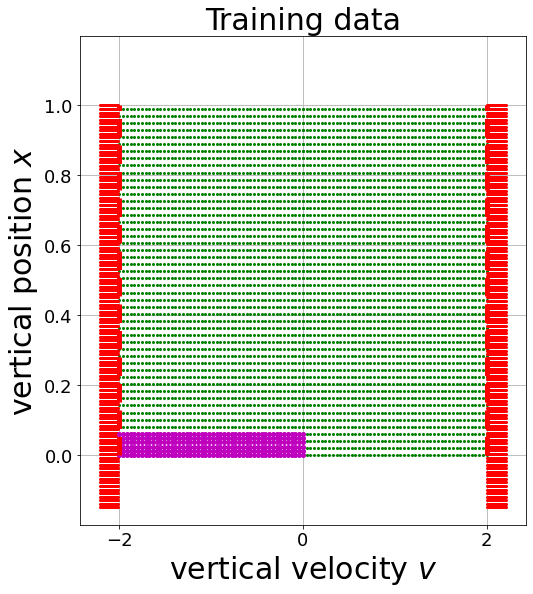

In [76]:
# Plot the training data
fs = 30 # fontsize
ms = 2  # markersize
plt.figure(figsize=(8,9))
plt.plot(X_expert[:,1], X_expert[:,0], 'g.', markersize=2.0*ms)
plt.plot(X_buffer[:,1], X_buffer[:,0], 'g.', markersize=2.0*ms)
# plt.plot(X_filter[:,1], X_filter[:,0], 'b.', markersize=ms)
plt.plot(X_unsafe[:,1], X_unsafe[:,0], 'r.', markersize=2.0*ms)
plt.plot(X_train_plot[:,1], X_train_plot[:,0], 'm.', markersize=4.0*ms)
plt.plot(-_VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0) # velocity bounds
plt.plot( _VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0)
plt.rc('xtick',labelsize=1.0*fs)
plt.rc('ytick',labelsize=1.0*fs)
plt.title('Training data',fontsize=fs)
plt.xlabel('vertical velocity $v$', fontsize=fs)
plt.ylabel('vertical position $x$', fontsize=fs)
plt.grid()
# plt.show()
# plt.xticks(np.arange(-2.5, 2.5+0.1, 0.5))
plt.yticks(np.arange(0.0, 1.1, 0.2))
# plt.xlim([-3, 3])
plt.ylim([-0.2, 1.2])
# plt.axis('equal')
plt.savefig('train_data.pdf', dpi=300)

## 2.3 Train/load a CBF

In [44]:
# Option 1: Load a trained CBF
params = np.load('params.npy', allow_pickle=True)

In [19]:
# Option 2: Learn a CBF from expert demonstrations

# Define the model for the CBF candidate. We use a fully connected two layer NN.
n_inputs  = 2 # state dimension
n_outputs = 1 # scalar valued
n_hidden  = 64

# Training parameters
block_size = 1000
num_blocks = 15
num_epochs = block_size * num_blocks
num_batches = 1

# Weights in the loss
lam_safe   = 4.0
lam_discrete = 1.0
lam_unsafe = 5.0
lam_dyn = 1.0
lam_param  = 0.01

# Slack variables
gamma_safe = dict({'expert': 0.0025, 'sample': 0.0025}) # second entry is not used
gamma_discrete = 0.0025
gamma_unsafe = 0.075
gamma_dyn = 0.055

In [20]:
# Initialize NN parameters (do not run if you want to start with existing params)
rng = PRNG(5433)
init_params = [
        [random.normal(rng.next(), shape=(n_inputs, n_hidden)), random.normal(rng.next(), shape=(n_hidden,))],
        [random.normal(rng.next(), shape=(n_hidden, n_outputs)), random.normal(rng.next(), shape=(n_outputs,))]
]
params = init_params

In [ ]:
# Main training loop
start_time = time.time()
opt_init, opt_update, get_params = optimizers.adam(step_size=cosine_decay(0.1, num_epochs * num_batches))
opt_state = opt_init(params)
key = rng.next()

for i in range(num_blocks):
    key, subkey = random.split(key)
    opt_state = tree_util.tree_map(
        lambda e: e.block_until_ready(), 
        optimize_nn_with_input(key, num_batches, X_dyn, X_expert, U_dyn, U_expert, None, X_filter, X_unsafe, get_params, 
                               opt_update, opt_state, i * block_size, block_size,
                               gamma_safe, gamma_unsafe, gamma_dyn, gamma_discrete, lam_safe, lam_unsafe, lam_dyn, lam_discrete, lam_param))

    print("epoch",(i+1)*block_size,"| loss",loss_with_input(X_dyn, X_expert, U_dyn, U_expert, None, X_filter, X_unsafe, get_params(opt_state), 
                                                            gamma_safe, gamma_unsafe, gamma_dyn, gamma_discrete, 
                                                            lam_safe, lam_unsafe, lam_dyn, lam_discrete, lam_param),    
          "| elapsed",time.time() - start_time,"seconds")
params = get_params(opt_state)
np.save('params.npy', params)

# Part 3: Safe Closed-loop Control with the Learned CBF

## 3.1 Safe Control with the learned CBF

In [77]:
# Create a reference trajectory
dt = _dt
initial_state = np.array([1.0, 0.0])
ref_traj = make_reference(initial_state, dt=dt, horizon=150)
# plot_traj([ref_traj], markersize=15)

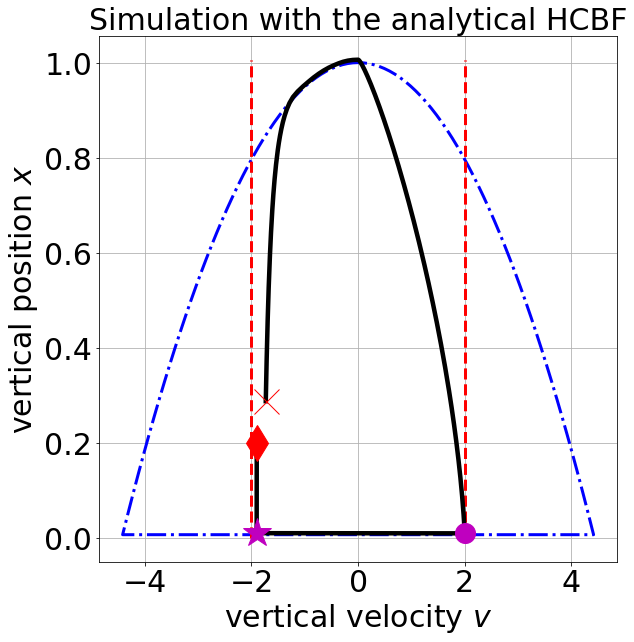

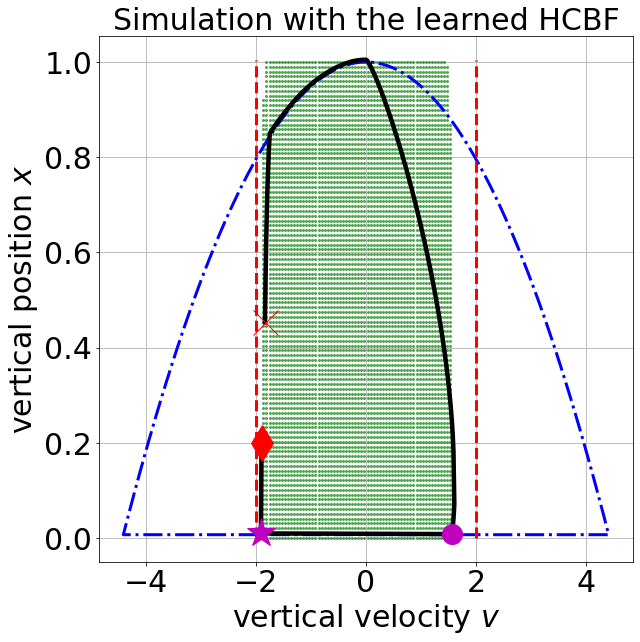

In [78]:
horizon = 225

initial_state = np.array([0.2, -1.9])

# Safe trial with the analytical CBF
nom_controller = TrackingLQR()
CBF_controller = true_CBF()
title = 'Simulation with the analytical HCBF'
cts_state_traj, dct_state_traj, cts_action_traj, dct_action_traj, event_traj =\
    Simulation(initial_state, ref_traj, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=True, title=title)

# Safe trial with the learned CBF
nom_controller = TrackingLQR()
CBF_controller = learned_CBF(params=params)
title = 'Simulation with the learned HCBF'
cts_state_traj, dct_state_traj, cts_action_traj, dct_action_traj, event_traj =\
    Simulation(initial_state, ref_traj, nom_controller, CBF_controller, dt, horizon, verbose=False, vis=True, title=title)

# Part 4: Validness of the Learned CBF

## 4.0 Functions for verification

In [67]:
def compute_eps(x_set):
# compute values of eps at each point
  def pairwise_rel(x1,x2):
    return x1-x2
  def rel(x, x_set):
    return vmap(pairwise_rel, in_axes=(None, 0))(x, x_set)
  def Euc_dist(x):
    return jnp.sqrt(jnp.dot(x,x))
  def Euc_dist_vec(x_set):
    return vmap(Euc_dist, in_axes=(0))(x_set)
  Eps = np.empty((0,1))
  for x in x_set:
    rel_t = rel(jnp.array(x), jnp.array(x_set))
    rel_dist_vec = Euc_dist_vec(rel_t)
    rel_dist_min = jnp.min(rel_dist_vec[jnp.where(rel_dist_vec>0)])
    Eps = np.vstack((Eps,rel_dist_min))
  return jnp.squeeze(Eps)

def compute_Lip_h_sample(x1, x2, u, params):
# estimate the local Lips. const. via sampled points
  return jnp.abs(q_with_input(x1, u, params)-q_with_input(x2, u, params))/jnp.sqrt(jnp.dot(x1-x2,x1-x2))

def compute_Lip_q(x, u, params):
# estimate the local Lips. const. of q at (x,u) via the norm of the gradient
  dq = grad(q_with_input, argnums=0)(x, u, params)
  return jnp.sqrt(jnp.dot(dq,dq))

def compute_Lip_h(x, params):
# estimate the local Lips. const. of h at x via the norm of the gradient
  dh = grad(h_model, argnums=0)(x, params)
  return jnp.sqrt(jnp.dot(dh,dh))

def compute_bar_X_safe_ineq(x_safe, x_unsafe_set, Lh):
  def norm_safe_unsafe(x_unsafe, x_safe):
    return jnp.sqrt(jnp.dot(x_unsafe-x_safe,x_unsafe-x_safe))
  inf_norm = jnp.min(vmap(norm_safe_unsafe, in_axes=(0, None))(x_unsafe_set, x_safe))
  return inf_norm - (gamma_unsafe+gamma_safe['expert'])/Lh

def certify_Lip(eps, L, gamma):
    return jnp.sign(eps - gamma/L)

def certify_gamma(f, gamma):
    return jnp.sign(f-gamma)

## 4.1 Prop. 3.1 ($\bar{\epsilon}$-nets covering $\mathcal{N}$ and $h(x_i) \leq - \gamma_{\rm{unsafe}}, \ x_i \in X_{\mathcal{N}}$)

In [51]:
# Compute \bar{eps} (no need to re-run if the training data doesn't change; Jax implementation of compute_eps causes OOM on Colab)
Eps_unsafe = compute_eps(X_unsafe[:200,:]) # only works when gridding
print('min(Eps_unsafe) =', min(Eps_unsafe))
print('max(Eps_unsafe) =', max(Eps_unsafe))
print('mean(Eps_unsafe) =', np.mean(Eps_unsafe))
print('median(Eps_unsafe) =', np.median(Eps_unsafe))
eps_unsafe = max(Eps_unsafe)

min(Eps_unsafe) = 0.01017699115044235
max(Eps_unsafe) = 0.010176991150442571
mean(Eps_unsafe) = 0.010176991150442459
median(Eps_unsafe) = 0.01017699115044246


In [79]:
# Check the Lips. conditions over the eps-net
Lh_unsafe = vmap(compute_Lip_h, in_axes=(0, None))(X_unsafe, params)
flag_Lh_unsafe = vmap(certify_Lip, in_axes=(None, 0, None))(eps_unsafe, Lh_unsafe, gamma_unsafe)
print('min(Lh_unsafe) =', min(Lh_unsafe))
print('max(Lh_unsafe) =', max(Lh_unsafe))
print('mean(Lh_unsafe) =', np.mean(Lh_unsafe))
print('median(Lh_unsafe) =', np.median(Lh_unsafe))

# Check h(x_i) + gamma_unsafe <= 0
h_unsafe = vmap(h_model, in_axes=(0, None))(X_unsafe, params)
flag_h_unsafe = vmap(certify_gamma, in_axes=(0, None))(h_unsafe, -gamma_unsafe)

# Suggestions for picking gamma_unsafe
print('')
print('*** Guidelines for choosing gamma_unsafe ( currently', gamma_unsafe, ') ***')
print('max(Eps_unsafe)*max(Lh_unsafe) =', max(Eps_unsafe)*max(Lh_unsafe))
print('mean(Eps_unsafe)*mean(Lh_unsafe) =', np.mean(Eps_unsafe)*np.mean(Lh_unsafe))
print('median(Eps_unsafe)*median(Lh_unsafe) =', np.median(Eps_unsafe)*np.median(Lh_unsafe))

min(Lh_unsafe) = 0.22615131467500024
max(Lh_unsafe) = 4.280045461532884
mean(Lh_unsafe) = 1.7414222114697235
median(Lh_unsafe) = 1.270224439785297

*** Guidelines for choosing gamma_unsafe ( currently 0.075 ) ***
max(Eps_unsafe)*max(Lh_unsafe) = 0.04355798478551205
mean(Eps_unsafe)*mean(Lh_unsafe) = 0.01772243843531131
median(Eps_unsafe)*median(Lh_unsafe) = 0.0129270628827707


Number of points satisfy the Lipschitz-covering condition: 4560 / 4560 ( 100.0 % ) - Bad points are marked with red cross
Number of points satisfy the slack condition h(x)+gamma<=0: 4405 / 4560 ( 96.6 % ) - Bad points are marked with yellow star



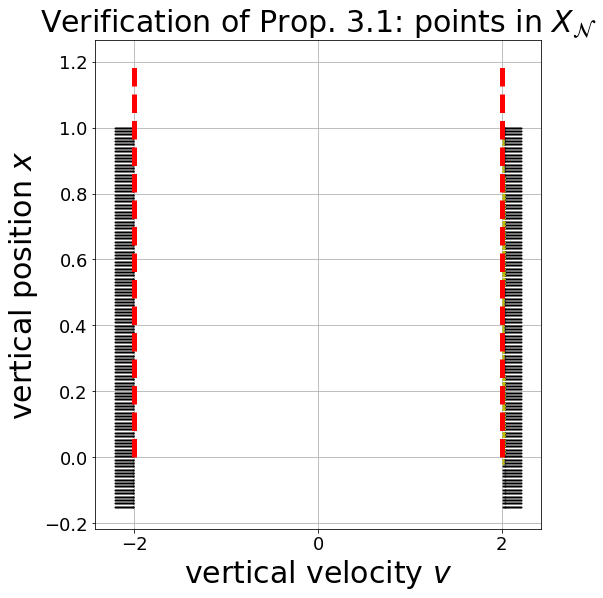

In [53]:
# Visualization of Prop. 3.1
fs = 30 # fontsize
ms = 2  # markersize
plt.figure(figsize=(8,9))

# all points in X_unsafe
plt.plot(X_unsafe[:,1], X_unsafe[:,0], 'k.', markersize=ms)
# points that do not satisfy Lips. conditions
plt.plot(X_unsafe[np.where(flag_Lh_unsafe>0)][:,1], X_unsafe[np.where(flag_Lh_unsafe>0)][:,0], 'rx', markersize=5*ms)
print('Number of points satisfy the Lipschitz-covering condition:', X_unsafe[np.where(flag_Lh_unsafe<=0)].shape[0], '/', X_unsafe.shape[0],\
      '(', np.round(X_unsafe[np.where(flag_Lh_unsafe<=0)].shape[0]/X_unsafe.shape[0]*100,2), '% ) - Bad points are marked with red cross')
# points that do not satisfy h(x)+gamma<=0
plt.plot(X_unsafe[np.where(flag_h_unsafe>0)][:,1], X_unsafe[np.where(flag_h_unsafe>0)][:,0], 'y*', markersize=ms)
print('Number of points satisfy the slack condition h(x)+gamma<=0:', X_unsafe[np.where(flag_h_unsafe<=0)].shape[0], '/', X_unsafe.shape[0],\
      '(', np.round(X_unsafe[np.where(flag_h_unsafe<=0)].shape[0]/X_unsafe.shape[0]*100,2), '% ) - Bad points are marked with yellow star')
print('')
# velocity bounds
plt.plot(-_VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0) 
plt.plot( _VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0)
# plot settings
plt.xlabel('vertical velocity $v$', fontsize=fs)
plt.ylabel('vertical position $x$', fontsize=fs)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.title('Verification of Prop. 3.1: points in $X_\mathcal{N}$',fontsize=fs)
plt.grid()

## 4.2 Corollary 3.2 ($\epsilon$-nets covering $\mathcal{D}$ and $h(x_i) \geq \gamma_{\rm{safe}}, \ x_i \in \bar{X}_{\rm{safe}}$)

In [56]:
# Compute eps (no need to re-run if the training data doesn't change; Jax implementation of compute_eps causes OOM on Colab)
Eps_safe = compute_eps(X_expert[:200,:]) # only works when gridding
print('min(Eps_safe) =', min(Eps_safe))
print('max(Eps_safe) =', max(Eps_safe))
print('mean(Eps_safe) =', np.mean(Eps_safe))
print('median(Eps_safe) =', np.median(Eps_safe))
eps_safe = max(Eps_safe)

min(Eps_safe) = 0.02020202020202011
max(Eps_safe) = 0.02020202020202022
mean(Eps_safe) = 0.020202020202020186
median(Eps_safe) = 0.0202020202020202


In [57]:
# Identify the set bar_X_safe (Split x_unsafe if OOM)
Lh = max(Lh_unsafe)
value_LHS = vmap(compute_bar_X_safe_ineq, in_axes=(0, None, None))(X_expert, X_unsafe, Lh)
# value_LHS = jnp.minimum(value_LHS_1, value_LHS_2)
bar_X_safe = X_expert[jnp.where(value_LHS>=0)]
print('Number of points in bar_X_safe:', bar_X_safe.shape[0], '/', X_expert.shape[0])
# bar_X_safe = X_expert

Number of points in bar_X_safe: 4200 / 4200


In [80]:
# Check the Lips. conditions over the eps-net
Lh_safe = vmap(compute_Lip_h, in_axes=(0, None))(X_expert, params)
flag_Lh_safe = vmap(certify_Lip, in_axes=(None, 0, None))(eps_safe, Lh_safe, gamma_safe['expert'])
print('min(Lh_safe) =', min(Lh_safe))
print('max(Lh_safe) =', max(Lh_safe))
print('mean(Lh_safe) =', np.mean(Lh_safe))
print('median(Lh_safe) =', np.median(Lh_safe))

# Check h(x_i) - gamma_safe >= 0
h_safe = vmap(h_model, in_axes=(0, None))(bar_X_safe, params)
flag_h_safe = vmap(certify_gamma, in_axes=(0, None))(h_safe, gamma_safe['expert'])

# Suggestions for picking gamma_safe
print('')
print('*** Guidelines for choosing gamma_safe ( currently', gamma_safe, ') ***')
print('max(Eps_safe)*max(Lh_safe) =', max(Eps_safe)*max(Lh_safe))
print('mean(Eps_safe)*mean(Lh_safe) =', np.mean(Eps_safe)*np.mean(Lh_safe))
print('median(Eps_safe)*median(Lh_safe) =', np.median(Eps_safe)*np.median(Lh_safe))

min(Lh_safe) = 0.0056227482552374045
max(Lh_safe) = 0.13619108115362707
mean(Lh_safe) = 0.03156585046773453
median(Lh_safe) = 0.0217812810129224

*** Guidelines for choosing gamma_safe ( currently {'expert': 0.0025, 'sample': 0.0025} ) ***
max(Eps_safe)*max(Lh_safe) = 0.0027513349728005496
mean(Eps_safe)*mean(Lh_safe) = 0.0006376939488431213
median(Eps_safe)*median(Lh_safe) = 0.0004400258790489373


Number of points satisfy the Lipschitz-covering condition: 4150 / 4200 ( 98.81 % ) - Bad points are marked with red cross
Number of points satisfy the slack condition h(x)-gamma>=0: 4006 / 4200 ( 95.38 % ) - Bad points are marked with yellow star



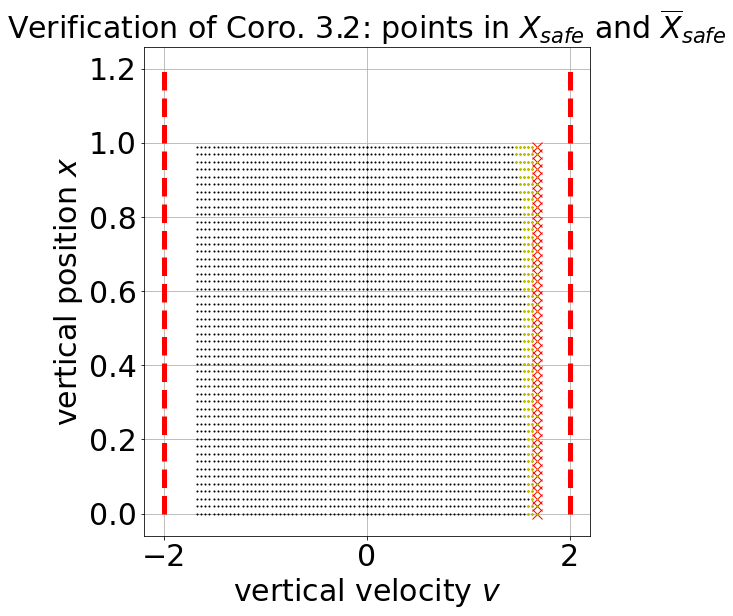

In [59]:
# Visualization of Coro. 3.2
fs = 30 # fontsize
ms = 2  # markersize
plt.figure(figsize=(8,9))

# all points in X_expert
plt.plot(X_expert[:,1], X_expert[:,0], 'k.', markersize=ms, alpha=0.1)
# all points in bar_X_safe
plt.plot(bar_X_safe[:,1], bar_X_safe[:,0], 'k.', markersize=ms, alpha=1.0)
# points that do not satisfy Lips. conditions
plt.plot(X_expert[np.where(flag_Lh_safe>0)][:,1], X_expert[np.where(flag_Lh_safe>0)][:,0], 'rx', markersize=5*ms)
print('Number of points satisfy the Lipschitz-covering condition:', X_expert[np.where(flag_Lh_safe<=0)].shape[0], '/', X_expert.shape[0],\
      '(', np.round(X_expert[np.where(flag_Lh_safe<=0)].shape[0]/X_expert.shape[0]*100,2), '% ) - Bad points are marked with red cross')
# points that do not satisfy h(x)+gamma<=0
plt.plot(bar_X_safe[np.where(flag_h_safe<0)][:,1], bar_X_safe[np.where(flag_h_safe<0)][:,0], 'y*', markersize=ms)
print('Number of points satisfy the slack condition h(x)-gamma>=0:', bar_X_safe[np.where(flag_h_safe>=0)].shape[0], '/', bar_X_safe.shape[0],\
      '(', np.round(bar_X_safe[np.where(flag_h_safe>=0)].shape[0]/bar_X_safe.shape[0]*100,2), '% ) - Bad points are marked with yellow star')
print('')
# velocity bounds
plt.plot(-_VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0) 
plt.plot( _VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0)
# plot settings
plt.xlabel('vertical velocity $v$', fontsize=fs)
plt.ylabel('vertical position $x$', fontsize=fs)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.title('Verification of Coro. 3.2: points in $X_{safe}$ and $\overline{X}_{safe}$',fontsize=fs)
plt.grid()

## 4.3 Prop. 3.3 ($\epsilon$-nets covering $\mathcal{D}$ and $q(x_i) \geq \gamma_{\rm{dyn}}, \ x_i \in X_{\rm{safe}}$)

In [81]:
# Check the Lips. conditions over the eps-net
Lq = vmap(compute_Lip_q, in_axes=(0, 0, None))(X_expert, U_expert, params)
flag_Lq = vmap(certify_Lip, in_axes=(None, 0, None))(eps_safe, Lq, gamma_dyn)
print('min(Lq) =', min(Lq))
print('max(Lq) =', max(Lq))
print('mean(Lq) =', np.mean(Lq))
print('median(Lq) =', np.median(Lq))

# q(x_i) constraint is always satisfied

# Suggestions for picking gamma_dyn
print('')
print('*** Guidelines for choosing gamma_dyn ( currently', gamma_dyn, ') ***')
print('max(Eps_safe)*max(Lq) =', max(Eps_safe)*max(Lq))
print('mean(Eps_safe)*mean(Lq) =', np.mean(Eps_safe)*np.mean(Lq))
print('median(Eps_safe)*median(Lq) =', np.median(Eps_safe)*np.median(Lq))

min(Lq) = 0.0007689904688364246
max(Lq) = 4.003688169250374
mean(Lq) = 0.4769889801347239
median(Lq) = 0.16677994442004068

*** Guidelines for choosing gamma_dyn ( currently 0.055 ) ***
max(Eps_safe)*max(Lq) = 0.08088258927778541
mean(Eps_safe)*mean(Lq) = 0.009636141012822697
median(Eps_safe)*median(Lq) = 0.003369291806465468


Number of points satisfy the Lipschitz-covering condition: 4147 / 4200 ( 98.74 % ) - Bad points are marked with red cross
Slack conditions on q(x_i) are always satisfied as the input is unconstrained and system is fully-actuated



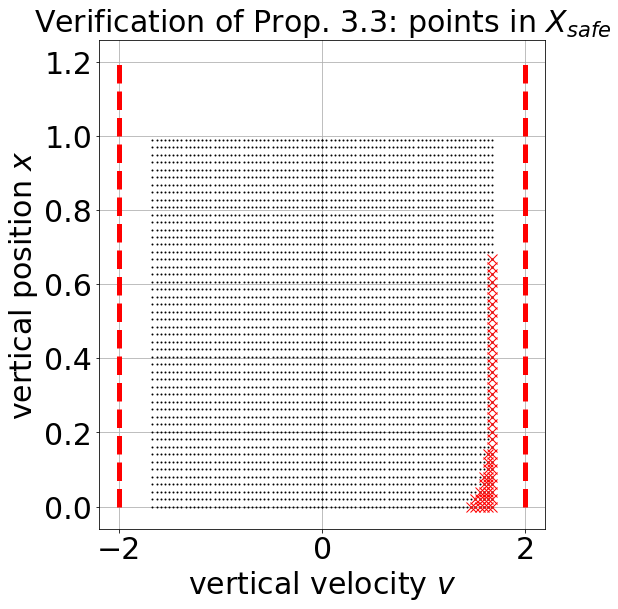

In [70]:
# Visualization of Prop. 3.3
fs = 30 # fontsize
ms = 2  # markersize
plt.figure(figsize=(8,9))

# all points in X_expert
plt.plot(X_expert[:,1], X_expert[:,0], 'k.', markersize=ms, alpha=1.0)
# points that do not satisfy Lips. conditions
plt.plot(X_expert[np.where(flag_Lq>0)][:,1], X_expert[np.where(flag_Lq>0)][:,0], 'rx', markersize=5*ms)
print('Number of points satisfy the Lipschitz-covering condition:', X_expert[np.where(flag_Lq<=0)].shape[0], '/', X_expert.shape[0],\
      '(', np.round(X_expert[np.where(flag_Lq<=0)].shape[0]/X_expert.shape[0]*100,2), '% ) - Bad points are marked with red cross')
print('Slack conditions on q(x_i) are always satisfied as the input is unconstrained and system is fully-actuated')
print('')
# velocity bounds
plt.plot(-_VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0) 
plt.plot( _VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.0,5), 'r--', linewidth=5.0)
# plot settings
plt.xlabel('vertical velocity $v$', fontsize=fs)
plt.ylabel('vertical position $x$', fontsize=fs)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.title('Verification of Prop. 3.3: points in $X_{safe}$',fontsize=fs)
plt.grid()

## 4.4 Find forward invariant regions via state-space gridding

In [71]:
# First grid a region of interest
eps_grid = 1e-2
POS_grid = np.linspace(-0.2, 1.2, int(1.4/eps_grid))
x_grid = np.empty((0,2))
for v in np.linspace(-2.2, 2.2, int(4.4/eps_grid)):
  x_grid_t = np.column_stack((POS_grid, v*np.ones_like(POS_grid)))
  x_grid = np.vstack((x_grid, x_grid_t))
print('Number of gridding points:', x_grid.shape[0])

Number of gridding points: 61600


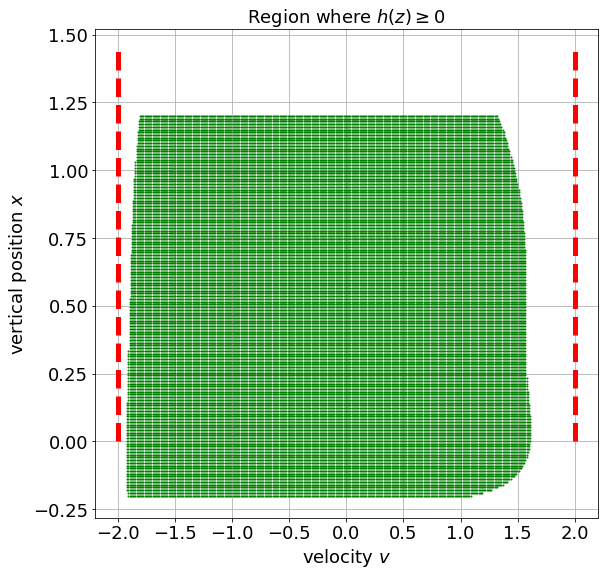

In [73]:
# Evaluate h(x) at each gridding point x
h_sample = vmap(h_model, in_axes=(0, None))(x_grid, params)

# Visualization
fs = 18 # fontsize
ms = 2  # markersize
plt.figure(figsize=(9,9))

# all points that h(x)>=0
x_grid_safe = x_grid[jnp.where(h_sample>=0.0)]
plt.plot(x_grid_safe[:,1], x_grid_safe[:,0], 'g.', markersize=ms, alpha=1.0)

# velocity bounds
plt.plot(-_VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.2,5), 'r--', linewidth=5.0) 
plt.plot( _VEL_BOUND*np.ones(5,), np.linspace(0,max(POS_grid)*1.2,5), 'r--', linewidth=5.0)

# plot settings
plt.title('Region where $h(z) \geq 0$',fontsize=fs)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.xlabel('velocity $v$', fontsize=fs)
plt.ylabel('vertical position $x$', fontsize=fs)
plt.grid()
plt.show()